 # 天池贷款违约预测竞赛 - Logistic Regression Baseline



 **竞赛链接**：[天池-零基础入门金融风控-贷款违约预测](https://tianchi.aliyun.com/competition/entrance/531830/information)



 **模型介绍**：

 本版本使用 **逻辑回归 (Logistic Regression, LR)** 作为基线模型。



 **逻辑回归的特点（根据风控经验）**：

 * **优势**：

     * **解释性极强**：权重（Weight）直接反映特征对违约概率的影响方向和大小。

     * **训练速度极快**：适合快速验证数据管道。

     * **工业界基石**：评分卡（Scorecard）模型的基础。

 * **劣势**：

     * **拟合能力弱**：只能处理线性关系，难以捕捉复杂的非线性模式。

     * **对数据敏感**：需要进行数据标准化处理。



 **主要流程**：

 1.  **数据读取与清洗**（同 LightGBM 版）。

 2.  **特征工程**（同 LightGBM 版）。

 3.  **数据标准化**：<span style="color:red">LR 特有步骤</span>，使用 StandardScaler 缩放数据。

 4.  **模型训练**：使用 LogisticRegression 进行 5折交叉验证。

 5.  **权重分析**：<span style="color:red">LR 特有步骤</span>，查看哪些特征最重要。

 6.  **结果输出**。

 ## 1. 导入需要的包



 除了基础包，我们引入 `LogisticRegression` 和 `StandardScaler`。

In [1]:
import os
import gc
import re
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 引入逻辑回归和标准化工具
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings("ignore")


 ## 2. 导入数据与合并

In [2]:
def load_data(train_path, test_path):
    print(f"正在读取数据...\n训练集: {train_path}\n测试集: {test_path}")
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"训练集大小: {train_df.shape}")
    print(f"测试集大小: {test_df.shape}")
    return train_df, test_df

TRAIN_FILE = "./train.csv"
TEST_FILE = "./testA.csv"

train_data, test_data = load_data(TRAIN_FILE, TEST_FILE)

# 分离标签
target = train_data['isDefault']
train_data = train_data.drop(['isDefault'], axis=1)

# 合并数据
data = pd.concat([train_data, test_data], ignore_index=True)
print(f"合并后数据总大小: {data.shape}")


正在读取数据...
训练集: ./train.csv
测试集: ./testA.csv
训练集大小: (800000, 47)
测试集大小: (200000, 46)
合并后数据总大小: (1000000, 46)


 ## 3. 数据清洗与缺失值处理
 LR 对缺失值非常敏感（无法直接计算），必须填充完整。

In [4]:
# 1. 就业年限
data['employmentLength'] = data['employmentLength'].fillna(0)
# 2. 匿名特征
data['n11'] = data['n11'].fillna(0)
data['n12'] = data['n12'].fillna(0)
# 3. 众数填充
for col in ['employmentTitle', 'postCode', 'title']:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mode()[0])
# 4. 均值填充
for col in ['dti', 'pubRecBankruptcies', 'revolUtil']:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())
# 5. 剩余匿名特征
numerical_features = list(data.select_dtypes(exclude=['object']).columns)
no_name_list = [col for col in numerical_features if col.startswith("n") and data[col].isnull().sum() > 0]
for col in no_name_list:
    data[col] = data[col].fillna(data[col].mode()[0])

print("缺失值填充完毕。")


缺失值填充完毕。


 ## 4. 特征工程

 将文本转为数字。

 *注意：对于逻辑回归，Label Encoding（0,1,2...）其实不是最佳选择（One-Hot更好），因为LR会认为 2>1。这里暂时沿用 Label Encoding。*

In [5]:
# --- EmploymentLength ---
def employment_length_to_int(s):
    if pd.isnull(s) or str(s) == 'nan': return 0
    s = str(s).strip()
    if '< 1' in s: return 0
    numbers = re.findall(r'\d+', s)
    return int(numbers[0]) if numbers else 0

data['employmentLength'] = data['employmentLength'].apply(employment_length_to_int)

# --- EarliesCreditLine ---
data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(str(s)[-4:]))

# --- Grade / SubGrade ---
for col in ['grade', 'subGrade']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# --- 删除日期 ---
if 'issueDate' in data.columns:
    data = data.drop(['issueDate'], axis=1)

print("特征工程完成。")


特征工程完成。


 ## 5. 数据标准化 (Normalization) - 关键步骤



 **为什么要做这一步？**

 逻辑回归是通过梯度下降求解的，且权重系数的大小与特征数值的大小有关。

 * 比如 `loanAmnt`（贷款金额）可能是 10000。

 * 比如 `dti`（负债率）可能是 20。

 如果不标准化，模型会认为贷款金额的变化比负债率的变化更“剧烈”，从而导致无法收敛或权重失真。



 我们使用 `StandardScaler` 将所有特征转换为 均值=0，方差=1 的分布。

In [6]:
# 重新拆分训练集和测试集
train_features = data[:len(target)]
test_features = data[len(target):]

# 初始化标准化器
scaler = StandardScaler()

# 注意：为了严谨，应该只在训练集上 fit，然后 transform 测试集
# 这里我们在整个训练集上 fit，稍后在 CV 中其实最好也是 Fold 内部 fit，但作为 Baseline 这样处理更简单且速度快
print("开始数据标准化...")
# 将 DataFrame 转换为 numpy array，因为 sklearn 输出的是 array
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

print("数据标准化完成。")
print(f"标准化后均值样例 (应接近0): {X_train_scaled.mean(axis=0)[:5]}")


开始数据标准化...
数据标准化完成。
标准化后均值样例 (应接近0): [ 0.00000000e+00 -9.37916411e-17  1.23634436e-17  2.01083594e-16
 -1.00044417e-16]


 ## 6. 模型训练 (Logistic Regression)



 使用 `LogisticRegression` 替代 LightGBM。

 * `C`: 正则化强度的倒数。C越小，正则化越强（防止过拟合）。

 * `solver`: 优化算法，'saga' 或 'liblinear' 适合大数据集。

 * `max_iter`: 最大迭代次数，如果数据量大，需要增加此值保证收敛。

In [7]:
# 准备交叉验证
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2023)

# 存储结果
oof_preds_lr = np.zeros(len(train_features))
test_preds_lr = np.zeros((len(test_features), nfold))
# 存储系数，用于后续分析解释性
feature_importance_list = []

print(f"\n开始 {nfold} 折逻辑回归训练...")
start_time = time.time()

for i, (train_index, valid_index) in enumerate(skf.split(train_features, target)):
    print(f"--- Fold {i + 1} ---")
    
    # 切分数据 (使用标准化后的数据)
    X_train_fold, y_train_fold = X_train_scaled[train_index], target.iloc[train_index]
    X_valid_fold, y_valid_fold = X_train_scaled[valid_index], target.iloc[valid_index]
    
    # 定义 LR 模型
    clf = LogisticRegression(
        penalty='l2',       # L2 正则化
        C=0.1,              # 正则化强度 (可调参)
        solver='saga',      # 求解器，saga 适合大数据
        n_jobs=-1,          # 并行计算
        max_iter=1000,      # 最大迭代次数
        random_state=2023
    )
    
    # 训练
    clf.fit(X_train_fold, y_train_fold)
    
    # 预测概率 (predict_proba 返回 [不违约概率, 违约概率])
    # 我们取 [:, 1] 即违约的概率
    valid_prob = clf.predict_proba(X_valid_fold)[:, 1]
    oof_preds_lr[valid_index] = valid_prob
    
    # 预测测试集
    test_preds_lr[:, i] = clf.predict_proba(X_test_scaled)[:, 1]
    
    # 记录当前折的 AUC
    fold_auc = roc_auc_score(y_valid_fold, valid_prob)
    print(f"Fold {i+1} AUC: {fold_auc:.5f}")
    
    # 记录系数 (Coefficients)
    feature_importance_list.append(clf.coef_[0])

end_time = time.time()
print(f"\n训练结束，耗时: {end_time - start_time:.2f} 秒")



开始 5 折逻辑回归训练...
--- Fold 1 ---
Fold 1 AUC: 0.71141
--- Fold 2 ---
Fold 2 AUC: 0.70874
--- Fold 3 ---
Fold 3 AUC: 0.71324
--- Fold 4 ---
Fold 4 AUC: 0.71083
--- Fold 5 ---
Fold 5 AUC: 0.71061

训练结束，耗时: 198.77 秒


 ## 7. 结果评估与可解释性分析 (Interpretability)



 这是逻辑回归最强大的地方。我们可以直接看权重（Coefficients）。

 * **正系数 (+)**：该特征数值越大，违约概率越高（风险因素）。

 * **负系数 (-)**：该特征数值越大，违约概率越低（安全因素）。


=== 逻辑回归 最终 CV AUC: 0.71096 ===
(注：逻辑回归分数通常低于 LightGBM，这是正常的，因为它无法捕捉复杂的非线性关系)

--- 逻辑回归特征权重分析 (Top 10) ---
Coefficient > 0 表示正相关 (易违约)，Coefficient < 0 表示负相关 (不易违约)
         Feature  Coefficient
6       subGrade     0.432466
24      totalAcc    -0.320996
2           term     0.245161
36            n6     0.155963
40           n10    -0.147294
19       openAcc     0.142387
10  annualIncome    -0.134638
15           dti     0.119528
38            n8     0.119236
4    installment     0.110551


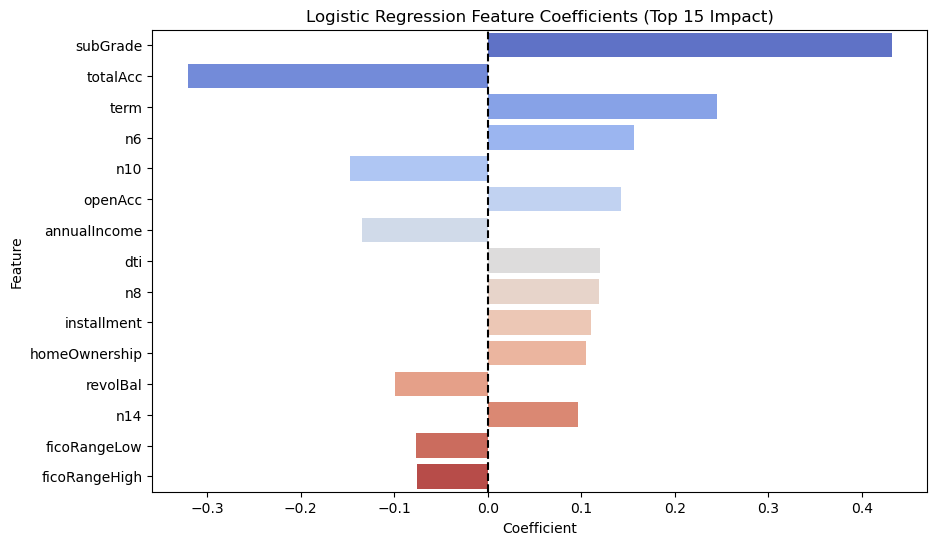

In [8]:
# 1. 计算总 AUC
score = roc_auc_score(target, oof_preds_lr)
print(f"\n=== 逻辑回归 最终 CV AUC: {score:.5f} ===")
print("(注：逻辑回归分数通常低于 LightGBM，这是正常的，因为它无法捕捉复杂的非线性关系)")

# 2. 解释性分析：查看特征权重
# 计算 5 折的平均权重
avg_coef = np.mean(feature_importance_list, axis=0)
feature_names = train_features.columns

# 创建 DataFrame 并排序
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': avg_coef})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\n--- 逻辑回归特征权重分析 (Top 10) ---")
print("Coefficient > 0 表示正相关 (易违约)，Coefficient < 0 表示负相关 (不易违约)")
print(coef_df[['Feature', 'Coefficient']].head(10))

# 可视化前 15 个重要特征
plt.figure(figsize=(10, 6))
# 取绝对值最大的前15个
top_features = coef_df.head(15)
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')
plt.title('Logistic Regression Feature Coefficients (Top 15 Impact)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()


 ## 8. 生成提交文件

In [9]:
submission = pd.DataFrame()
submission['id'] = test_data['id'] if 'id' in test_data.columns else range(len(test_preds_lr))
submission['isDefault'] = test_preds_lr.mean(axis=1)

output_file = 'submit_lr.csv'
submission.to_csv(output_file, index=False)
print(f"提交文件已保存至: {output_file}")

提交文件已保存至: submit_lr.csv
